In [4]:
import numpy as np
import qcodes as qc
import os
from qcodes import (Measurement,
                    experiments,
                    initialise_database,
                    initialise_or_create_database_at,
                    load_by_guid,
                    load_by_run_spec,
                    load_experiment,
                    load_last_experiment,
                    load_or_create_experiment,
                    new_experiment,
                    ManualParameter)
import matplotlib.pyplot as plt

db_name = "GeSiNW_Qubit_VTI01_Jonas (2).db" # Database name
sample_name = "Butch" # Sample name
exp_name = "Qubit_Search" # Experiment name

db_file_path = os.path.join(os.getcwd(), db_name)
qc.config.core.db_location = db_file_path
initialise_or_create_database_at(db_file_path)

experiment = load_or_create_experiment(experiment_name = exp_name,
                                       sample_name = sample_name)

# High-resolution Data

In [2]:
Negatives = [[97,98], [99,100], [101,102], [103,104], [105,106], [107,108], [109,110], [111,112], [117,118], [119,120], [122,123], [124,125],
[127,128], [130,131]]

Positives = [[113,114], [115,116]]

neg_high_res_blocked = []
neg_high_res_unblocked = []

for pair in Negatives:

    blocked = load_by_run_spec(captured_run_id = pair[0] ).to_xarray_dataset()
    unblocked = load_by_run_spec(captured_run_id= pair[1]).to_xarray_dataset()
    neg_high_res_blocked.append(-blocked['I_SD'].to_numpy())
    neg_high_res_unblocked.append(-unblocked['I_SD'].to_numpy())
    
    
pos_high_res_blocked = []
pos_high_res_unblocked = []    

for pair in Positives:

    blocked = load_by_run_spec(captured_run_id = pair[0] ).to_xarray_dataset()
    unblocked = load_by_run_spec(captured_run_id= pair[1]).to_xarray_dataset()
    
    pos_high_res_blocked.append(-blocked['I_SD'].to_numpy())
    pos_high_res_unblocked.append(-unblocked['I_SD'].to_numpy())
    

high_res_blocked = neg_high_res_blocked + pos_high_res_blocked
high_res_unblocked = neg_high_res_unblocked + pos_high_res_unblocked

labels = np.zeros(len(high_res_blocked))
labels[-1] = 1
labels[-2] = 1

In [14]:
import btriangle_detection, btriangle_properties
import cv2 as cv
from btriangle_detection import PSB_detector, triangle_segmentation_alg
from btriangle_properties import detect_base



def bias_triangle_pipeline(img: np.ndarray, res: int, min_area: int, thr_method: str, denoising: bool, allow_MET: bool, direction: str, median: bool = False) -> None:

    gray_orig, ims, masks = btriangle_detection.triangle_segmentation_alg(img, res = res, min_area = min_area, thr_method = thr_method, denoising = denoising, allow_MET = allow_MET, direction = direction)

    base, corner_pts, c_im = btriangle_properties.detect_base(gray_orig, masks, 'down')
    angles, angl_img = btriangle_properties.compute_angles(gray_orig, np.array(corner_pts), 'MET')

    print('The angles (as per MET) in degrees are ', angles)

    exc_state, line_mask = btriangle_properties.get_excited_state(gray_orig, base,'down', tol = 0.3)
    
    idx = np.argsort(exc_state[:, 1])
    exc_state = exc_state[idx, :]

    if median == True:
        
        median_line = len(idx) // 2
        ex_line = exc_state[median_line]
        
    else:
        ex_line = exc_state[-1]
    
    points = ex_line[2:]
    x_coords, y_coords = (points[0], points[2]), (points[1], points[3])
    slope_b, b_intc = btriangle_properties.get_line(base.flatten())
    y_int = np.mean([points[1] - points[0]*slope_b, points[3] - points[2]*slope_b])
    n_y1 = slope_b* points[0]+y_int
    n_y2 = slope_b* points[2]+y_int
 
    ex_line = np.array([slope_b, y_int, points[0], n_y1, points[2], n_y2])

    contour, _ = cv.findContours(masks,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    intersection = btriangle_properties.extract_triangle_seg(gray_orig, base, ex_line, contour[0])
    _, _ , tr_int = btriangle_properties.extract_props(intersection, gray_orig)

    _, _ , tr_int_all = btriangle_properties.extract_props(contour[0], gray_orig)

    blank = gray_orig.copy()
    seg_im = cv.drawContours(blank, [intersection], -1,(255,0,255), thickness=1)

    axes_points,axes,line_img = btriangle_properties.detect_detuning_axis(gray_orig, base, corner_pts)

    print('The mean intensity of the segment is', tr_int, 'while the mean intensity of the triangle is', tr_int_all)
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6),sharex=True, sharey=True)

    ax[0,0].imshow(gray_orig) 
    ax[0,0].axis('off') 
    ax[0,0].set_title('Original') 

    
    ax[0,1].imshow(ims[0]) 
    ax[0,1].axis('off') 
    ax[0,1].set_title('Segmentation') 

    ax[0,2].imshow(masks) 
    ax[0,2].axis('off') 
    ax[0,2].set_title('Mask') 


    ax[0,3].imshow(c_im) 
    ax[0,3].axis('off') 
    ax[0,3].set_title('Corner Points & Base') 

    ax[1,0].imshow(angl_img) 
    ax[1,0].axis('off') 
    ax[1,0].set_title('Convex Enclosing Triangle (MET)') 


    ax[1,1].imshow(line_mask) 
    ax[1,1].axis('off') 
    ax[1,1].set_title('Detected lines') 

    ax[1,2].imshow(seg_im) 
    ax[1,2].axis('off') 
    ax[1,2].set_title('Triangle Segment')

    ax[1,3].imshow(line_img) 
    ax[1,3].axis('off') 
    ax[1,3].set_title('Detected Detuning Axes')

    fig.tight_layout()
    
    return fig

The angles (as per MET) in degrees are  [62.39921985488739, 64.74673941931626, 52.85404072579636]
The mean intensity of the segment is 57.532813217072054 while the mean intensity of the triangle is 84.39789520824003


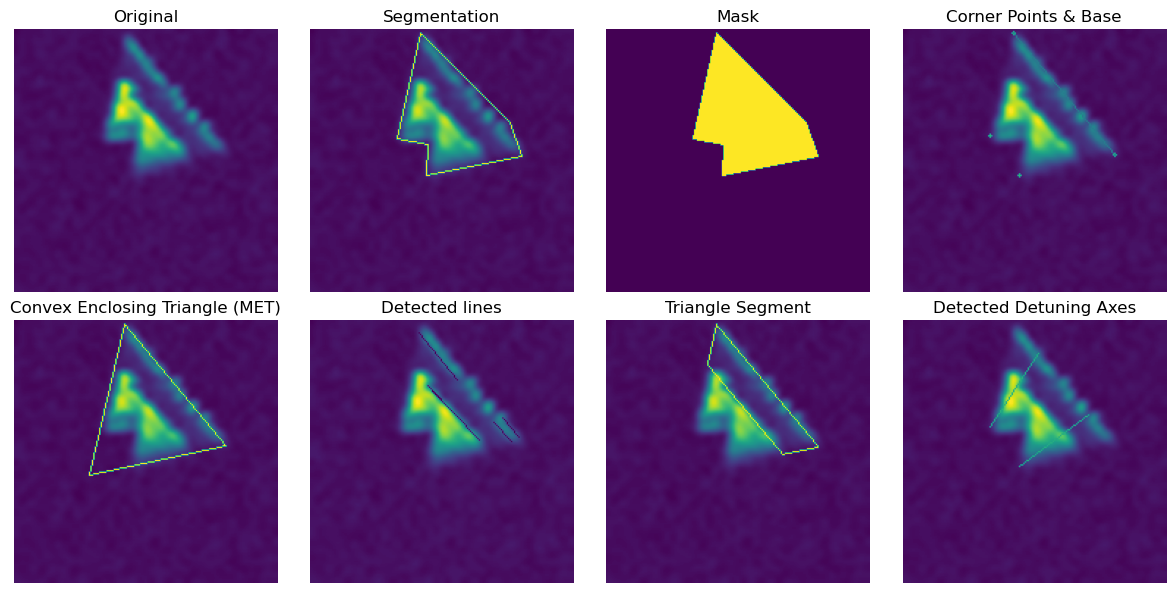

In [15]:
res_h = 4
min_area_pc = 0.001
min_area_h = (high_res_unblocked[-1].shape[0]*high_res_unblocked[-1].shape[1]*res_h*res_h)*min_area_pc

bias_triangle_pipeline(high_res_unblocked[-2],res = res_h, min_area = min_area_h, thr_method = 'triangle', denoising = True, allow_MET = True, direction = 'down')
plt.show()

# Lower-resolution data

In [16]:
db_name = "GeSiNW_Qubit_VTI01_Jonas.db" # Database name
sample_name = "Butch" # Sample name
exp_name = "Qubit_Search" # Experiment name

db_file_path = os.path.join(os.getcwd(), db_name)
qc.config.core.db_location = db_file_path
initialise_or_create_database_at(db_file_path)

experiment = load_or_create_experiment(experiment_name = exp_name,
                                       sample_name = sample_name)

data_with_magnet = load_by_run_spec(captured_run_id=5).to_xarray_dataset()
data_without_magnet = load_by_run_spec(captured_run_id=6).to_xarray_dataset()

data_with_magnet_neg_bias = load_by_run_spec(captured_run_id=7).to_xarray_dataset()
data_without_magnet_neg_bias = load_by_run_spec(captured_run_id=8).to_xarray_dataset()

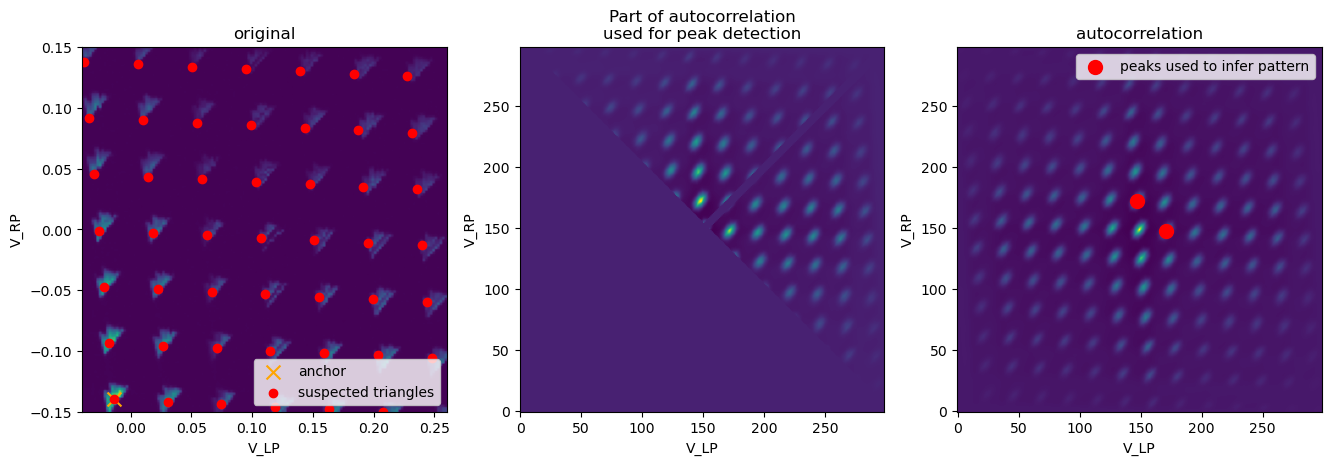

In [17]:
from btriangle_location_detection import get_locations
data_I_SD = data_with_magnet['I_SD']
data_I_SD_low_magnet = data_without_magnet['I_SD']
data = data_with_magnet


axes_values = []
axes_values_names = []
axes_units = []
for item, n in dict(data.dims).items():
    axes_values.append(data[item].to_numpy())
    axes_values_names.append(data[item].long_name)
    axes_units.append(data[item].unit)


x_array = axes_values[0]
y_array = axes_values[1]

x_name = axes_values_names[0]
y_name = axes_values_names[1]

anchor, peaks_px, peaks, all_triangles_px, all_triangles, fig = get_locations(-data_I_SD.to_numpy().T, x_array, y_array, x_name, y_name, return_figure = True, plot=True)

In [18]:
def cutout(img: np.ndarray, blob: np.ndarray, sidelength: int = 50) -> np.ndarray:
    """
    Cuts out a square region from the image centered around the blob.

    Args:
        img (np.ndarray): The input image.
        blob (np.ndarray): The blob around which to cut out.
        sidelength (int, optional): The sidelength of the square to cut out. Defaults to 50.

    Returns:
        np.ndarray: The cut out image.
    """
    x_bottom = (
        int(blob[0] - sidelength / 2) if int(blob[0] - sidelength / 2) >= 0 else 0
    )
    x_top = int(blob[0] + sidelength / 2) if int(blob[0] + sidelength / 2) >= 0 else 0
    y_bottom = (
        int(blob[1] - sidelength / 2) if int(blob[1] - sidelength / 2) >= 0 else 0
    )
    y_top = int(blob[1] + sidelength / 2) if int(blob[1] + sidelength / 2) >= 0 else 0
    img_save = img.copy()
    img = img[x_bottom:x_top, y_bottom:y_top]
    while img.shape[0] != img.shape[1]:
        sidelength -= 1
        img = cutout(img_save, blob, sidelength)
    return img

The angles (as per MET) in degrees are  [74.85901616492309, 46.10474036715041, 59.03624346792648]
The mean intensity of the segment is 79.77871148459384 while the mean intensity of the triangle is 83.27576403695807


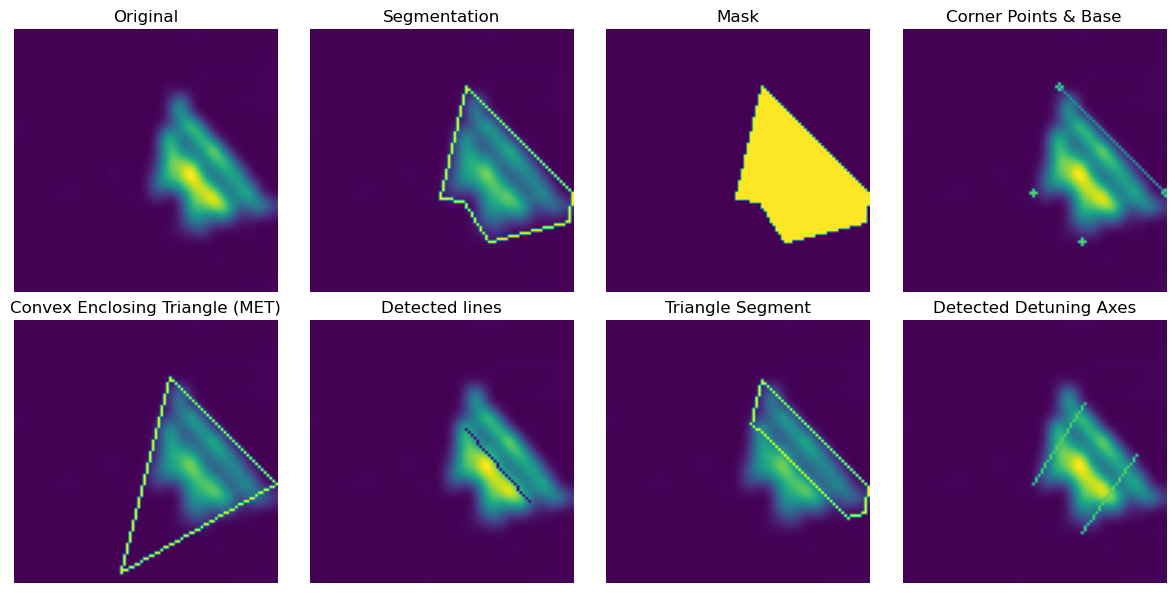

In [31]:
sidelength = np.max(peaks_px)
img_high_magnet = -data_I_SD.to_numpy().T
img_low_magnet = -data_I_SD_low_magnet.to_numpy().T

location = all_triangles_px[25]

img_block_cutout = cutout(img_low_magnet, location, sidelength= sidelength)
img_leak_cutout = cutout(img_high_magnet, location, sidelength= sidelength)

res_h = 4
min_area_pc = 0.001
min_area_h = (high_res_unblocked[-1].shape[0]*high_res_unblocked[-1].shape[1]*res_h*res_h)*min_area_pc

bias_triangle_pipeline(img_leak_cutout,res = res_h, min_area = min_area_h, thr_method = 'triangle', denoising = True, allow_MET = True, direction = 'down')
plt.show()

The configs for the __segmentation__, i.e. _triangle_segmentation_alg()_  are 

The scaling factor __res_h__ = 4 (for initial low_res classification, for the next stage high_res classification, __res_h__ = 2 can be enough)
The percentage __min_area_pc__ = 0.001 of the total image area (given by __min_area_h__) that is excluded from segmentation as outlier

The thresholding method __thr_method__ = 'triangle', if denoising is applied __denoising__ = True, if triangles have large gaps, __allow_MET__ = True, the direction of triangles __direction__ = 'down'

The configs for the __PSB detector__ are: 

The tolerance for deviation from the baseline slope in absolute value __slope_tol__ = 0.4,
The minimum value above which we have a potential PSB candidate __int_tol__ = 0.05,
__median__ = False. If the median (as ordered by y-intercept) is chosen to determine the triangle segment. If False, the outmost line is selected. 

In [35]:
PSB_List = []
intensity_pairs = []
intensity_diff = []

unblocked_list = []
blocked_list =[]

for location in all_triangles_px:
    
    img_block_cutout = cutout(img_low_magnet, location, sidelength= sidelength)
    img_leak_cutout = cutout(img_high_magnet, location, sidelength= sidelength)
    
    if img_block_cutout.shape[0] == sidelength and img_block_cutout.shape[1] == sidelength:
        
        
        res_h = 4
        min_area_pc = 0.001
        min_area_h = (img_leak_cutout.shape[0]*img_leak_cutout.shape[1]*res_h*res_h)*min_area_pc
        
        unblocked, ims, masks = triangle_segmentation_alg(img_leak_cutout, res = res_h, min_area = min_area_h, thr_method = 'triangle', denoising = True, allow_MET = True, direction = 'down')
        
        base, corner_pts, c_im = detect_base(unblocked, masks, 'down')
        
        min_area_h = (img_leak_cutout.shape[0]*img_block_cutout.shape[1]*res_h*res_h)*min_area_pc
        blocked,ims2, masks2 = triangle_segmentation_alg(img_block_cutout,res = res_h,min_area = min_area_h, thr_method = 'triangle', denoising = True,allow_MET = True, direction = 'down')

        pair, PSB = PSB_detector(unblocked, blocked, base, masks, 'down', slope_tol = 0.4, int_tol = 0.05, median = False)
        
        
        unblocked_list.append(unblocked)
        blocked_list.append(blocked)
        intensity_pairs.append(pair)
        
        
        if len(pair) > 0:
            
            intensity_diff.append(abs(pair[0]-pair[1]))
            
        else:
            
            intensity_diff.append(-1)
            
        PSB_List.append(int(PSB))
        
    else:
        
        PSB_List.append(None)
        intensity_pairs.append(None)
        intensity_diff.append(-1)
        
PSB_N = np.array(PSB_List)

from sklearn.metrics import recall_score, accuracy_score, precision_score

GT = [0]*len(PSB_N)
GT[23]=1
GT[25]=1
GT = np.array(GT)
idxs = np.where(PSB_N!=None)

print('The PSB detector is ',round(accuracy_score(GT[idxs].tolist(), PSB_N[idxs].tolist())*100,2),'% accurate, with recall ',round(recall_score(GT[idxs].tolist(), PSB_N[idxs].tolist())*100,2),'% and precision ', round(precision_score(GT[idxs].tolist(), PSB_N[idxs].tolist())*100,2),'%.')        

No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
The PSB detector is  77.42 % accurate, with recall  100.0 % and precision  22.22 %.


/Users/madeleine/Downloads/btriangle_properties.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y_coords)[0]


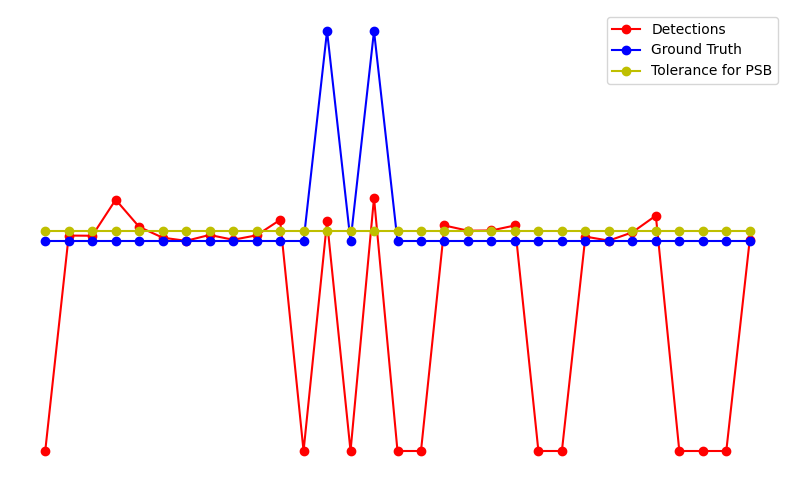

In [43]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(PSB_N[idxs])),np.array(intensity_diff)[idxs],'-or')
plt.plot(np.arange(0,len(PSB_N[idxs])),GT[idxs].tolist(),'-ob')
plt.plot(np.arange(0,len(PSB_N[idxs])),np.ones(len(idxs[0]))*0.05,'-oy')
plt.axis('off')
plt.legend(['Detections', 'Ground Truth', 'Tolerance for PSB'])
plt.show()

# Shape Matching

In [1]:
import pickle
with open('pulsed_msmt.pkl', 'rb') as f:
    data1 = pickle.load(f)
    
with open('unpulsed_msmt.pkl', 'rb') as f:
    data2 = pickle.load(f)    

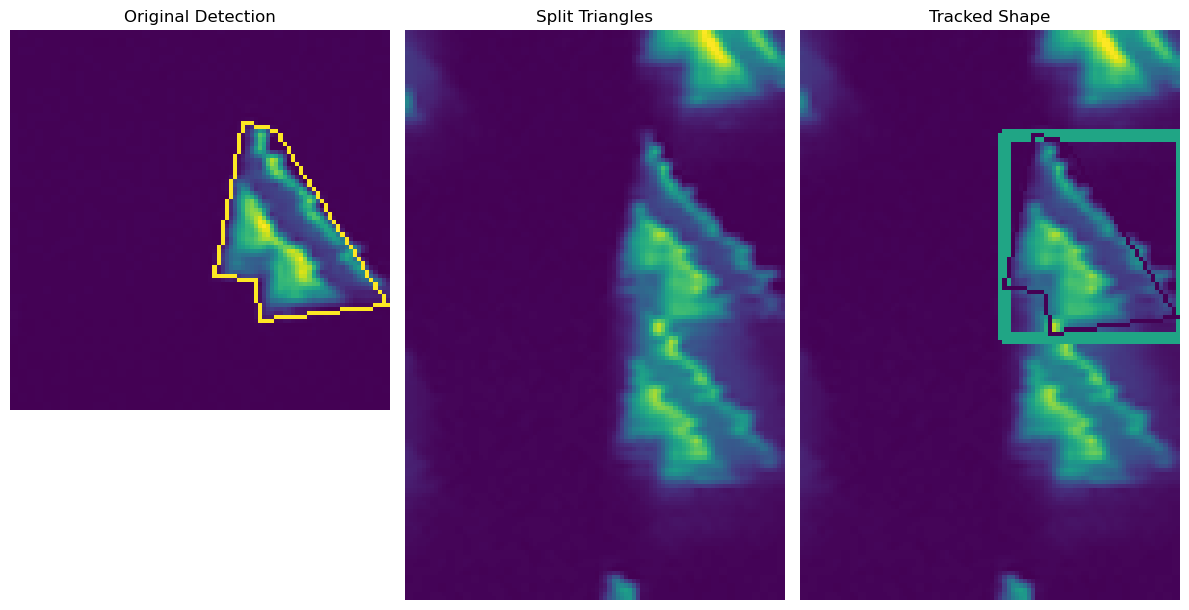

In [10]:
import btriangle_detection

res_h = 2
min_area_pc = 0.001
min_area_h = (data2['numpy_data'].shape[0]*data2['numpy_data'].shape[1]*res_h*res_h)*min_area_pc

gray_orig, ims, masks = btriangle_detection.triangle_segmentation_alg(-data2['numpy_data'],res = res_h,min_area = min_area_h, thr_method = 'triangle',inv = False, denoising = False, allow_MET = True, direction = 'down')
gray_orig2, _, _ = btriangle_detection.triangle_segmentation_alg(-data1['numpy_data'],res = res_h,min_area = 3, thr_method = 'triangle',inv = False, denoising = False, allow_MET = True, direction = 'down')

im, _,_ , new_contour = btriangle_detection.triangle_shape_matching(gray_orig, gray_orig2, masks)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),sharex=True, sharey=True)

ax[0].imshow(ims[0]) 
ax[0].axis('off') 
ax[0].set_title('Original Detection') 

ax[1].imshow(gray_orig2) 
ax[1].axis('off') 
ax[1].set_title('Split Triangles') 

ax[2].imshow(im) 
ax[2].axis('off') 
ax[2].set_title('Tracked Shape') 

fig.tight_layout()
plt.show() 

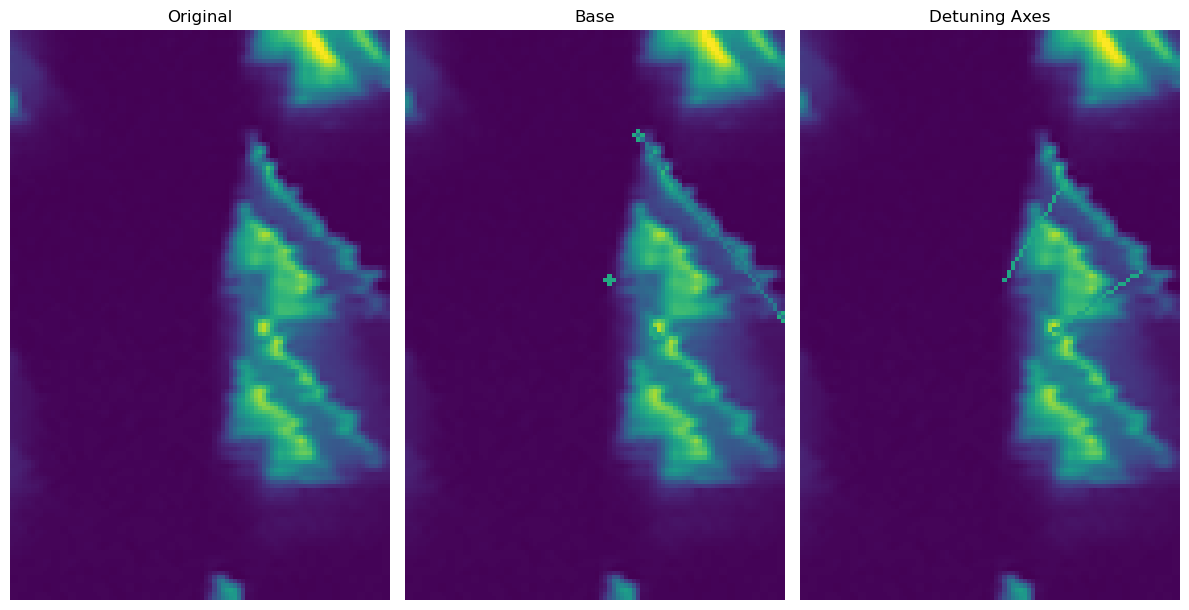

In [22]:
import cv2 as cv

mask_new = np.zeros(gray_orig2.shape, np.uint8)
cv.drawContours(mask_new, [new_contour], -1, (255, 255, 255), -1)

base, corner_pts, c_im = btriangle_properties.detect_base(gray_orig2, mask_new, 'down')
axes_points,axes,line_img = btriangle_properties.find_detuning_axes(gray_orig2, mask_new, direction = 'down', basis_cor = False)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),sharex=True, sharey=True)

ax[0].imshow(gray_orig2) 
ax[0].axis('off') 
ax[0].set_title('Original') 

ax[1].imshow(c_im) 
ax[1].axis('off') 
ax[1].set_title('Base') 

ax[2].imshow(line_img) 
ax[2].axis('off') 
ax[2].set_title('Detuning Axes') 
fig.tight_layout()
plt.show() 